In [101]:
import os
import json
import pandas as pd

import seaborn as sns

from os import listdir
from os.path import isfile, join, exists

TMP_DB_SQL = "/tmp/s2_tournament.sql"

logs_dir = "logs/"
logs = [f for f in listdir(logs_dir) if isfile(join(logs_dir, f))]
games = []
for log in logs:
    with open(logs_dir + "/" + log, "r") as f:
        games.append(json.load(f))

import sqlite3
if exists(TMP_DB_SQL):
    os.remove(TMP_DB_SQL)
con = sqlite3.connect(TMP_DB_SQL)
cur = con.cursor()
cur.execute('CREATE TABLE event_kill ("game", "round", "timestamp", "killerPlayfabId", "killerTeam", "victimPlayfabId", "victimTeam", "weaponName");')
cur.execute('CREATE TABLE event_cap ("game", "round", "mapName", "timestamp", "cappingTeam", "playfabId", "millisSinceStart");')
cur.execute('CREATE TABLE round ("game", "round", "mapName", "startTime", "endTime");')
cur.execute('CREATE TABLE player ("id", "name", "tier", "team");')


kills = []
for game in games:
    for round_no, round in enumerate(game["rounds"]):
        row = round
        row["round"] = round_no
        row["game"] = game["startTime"]
        cur.execute('insert into round values (:game, :round, :mapName, :startTime, :endTime)', row)
        for event in round["events"]:
            row = dict(event)
            del row["type"]
            if event["type"] == "PLAYER_KILL":
                row["game"] = game["startTime"]
                row["round"] = round_no
                cur.execute(
                    'insert into event_kill values (:game, :round, :timestamp, :killerPlayfabId, :killerTeam, :victimPlayfabId, :victimTeam, :weaponName)',
                    row)
            elif event["type"] == "FLAG_CAP":
                row["game"] = game["startTime"]
                row["mapName"] = round["mapName"]
                row["round"] = round_no
                row["millisSinceStart"] = event["timestamp"] - round["startTime"]
                cur.execute(
                    'insert into event_cap values (:game, :round, :mapName, :timestamp, :cappingTeam, :playfabId, :millisSinceStart)',
                    row)
con.commit()

In [102]:
players = [
    ["9EDB977D8849AD0C", "papu", 18, "WeAreTeam7"],
    ["EBA9074566BEA3E7", "proto", 16, "BaseHot"],
    ["EDB92702EC149828", "nino", 17, "Maroon5"],
    ["C19637F2290726EB", "haste", 13, "DotDotDot"],
    ["6446A9422BE1BD7D", "dD", 13, "NoMoreOverheat"],
    ["82FC63DE46014718", "YnGwi3", 13, "2Tilted"],
    ["D35B7050036AAD3", "fri", 13, "Mortals"],
    ["C42975C9A8E4E66B", "Psycho", 11, "DotDotDot"],
    ["517348F5DF244DE5", "Anna", 11, "Maroon5"],
    ["9AB6234BDDCE14D9", "dbfseventsd", 11, "Mortals"],
    ["9DD00BA9F5AA7525", "Norbo11", 10, "2Tilted"],
    ["47167D5CB3751A2C", "challz", 9, "NoMoreOverheat"],
    ["CF4B8D60F1735398", "thyro", 8, "WeAreTeam7"],
    ["D482320672E27418", "Jok", 8, "BaseHot"],
    ["784CD6C79930CC43", "evhO", 7, "BaseHot"],
    ["6AF4A5EF7DB4F012", "kahukerr", 1, "Mortals"],
    ["85D4CB1D1C2A72CD", "xQ:Le1T0r", 7, "WeAreTeam7"],
    ["B83C6CC780CDF96C", "SigHunter", 6, "2Tilted"],
    ["F029E4BFE212BE18", "Morgoth", 5, "Maroon5"],
    ["298FD01685544F0", "danyukhin", 0, "DotDotDot"],
    ["DEEA9A62468B4158", "kevin16king", 0, "NoMoreOverheat"],
]
cur.executemany("insert into player values(?,?,?,?)", players)
cur.connection.commit()

In [103]:
cur.execute('CREATE TABLE tier ("id", "name");')
players = [
    [0, "UNRANKED"],
    [1, "BRONZE_I"],
    [2, "BRONZE_II"],
    [3, "BRONZE_III"],
    [4, "SILVER_I"],
    [5, "SILVER_II"],
    [6, "SILVER_III"],
    [7, "GOLD_I"],
    [8, "GOLD_II"],
    [9, "GOLD_III"],
    [10, "PLATINUM_I"],
    [11, "PLATINUM_II"],
    [12, "PLATINUM_III"],
    [13, "DIAMOND_I"],
    [14, "DIAMOND_II"],
    [15, "DIAMOND_III"],
    [16, "CHAMPION_I"],
    [17, "CHAMPION_II"],
    [18, "CHAMPION_III"],
]
cur.executemany("insert into tier values(?,?)", players)
cur.connection.commit()

# Highlights

## fastest first cap, top 5

<AxesSubplot: xlabel='first_cap_seconds', ylabel='name'>

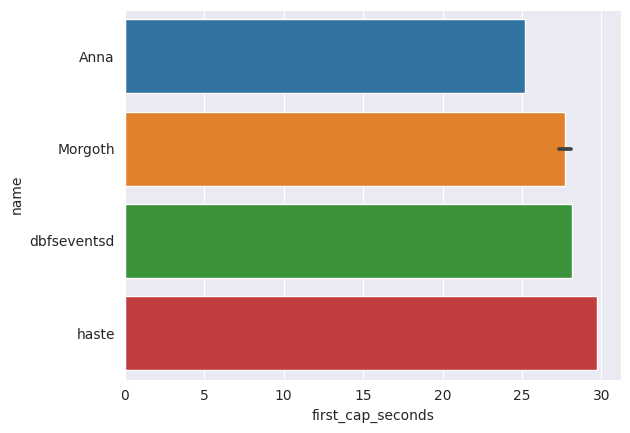

In [104]:
query = """
select game, round, name, team, mapName, round(1.0*min(millisSinceStart) / 1000,2) first_cap_seconds
from event_cap
join player on playfabId = player.id
group by game, round
order by first_cap_seconds
limit 5
"""
result1 = pd.read_sql_query(query, con)
sns.barplot(result1, y="name", x="first_cap_seconds")

In [105]:
result1

,game,round,name,team,mapName,first_cap_seconds
0,1671318701402,1,Anna,Maroon5,ctf_rotten,25.20
1,1671304340325,0,Morgoth,Maroon5,ctf_wretch,27.35
2,1671315355884,1,Morgoth,Maroon5,ctf_rotten,28.06
3,1671309040688,2,dbfseventsd,Mortals,ctf_Spark,28.17
4,1671311403164,0,haste,DotDotDot,ctf_division,29.72


## highest caps per round, top 3

<AxesSubplot: xlabel='avg_caps_per_round', ylabel='name'>

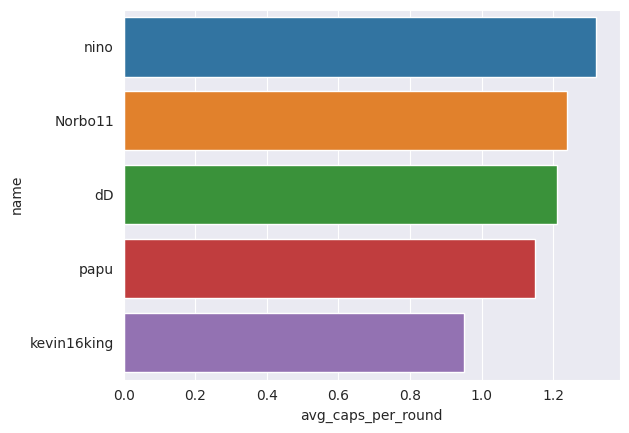

In [106]:
query = """
select name, team,
  round(1.0*count(1)/(select count(distinct game + " " + round) from event_kill where killerPlayfabId = player.id), 2) avg_caps_per_round,
  count(1) total_caps,
  (select count(distinct game + " " + round) from event_kill where killerPlayfabId = player.id) total_rounds
    from event_cap
join player on playfabId = player.id group by playfabId order by avg_caps_per_round desc limit 5
"""
result2 = pd.read_sql_query(query, con)
sns.barplot(result2, y="name", x="avg_caps_per_round")

In [107]:
result2

,name,team,avg_caps_per_round,total_caps,total_rounds
0,nino,Maroon5,1.32,25,19
1,Norbo11,2Tilted,1.24,21,17
2,dD,NoMoreOverheat,1.21,23,19
3,papu,WeAreTeam7,1.15,23,20
4,kevin16king,NoMoreOverheat,0.95,18,19


## highest k/d per team, top 3

<AxesSubplot: xlabel='kd', ylabel='team'>

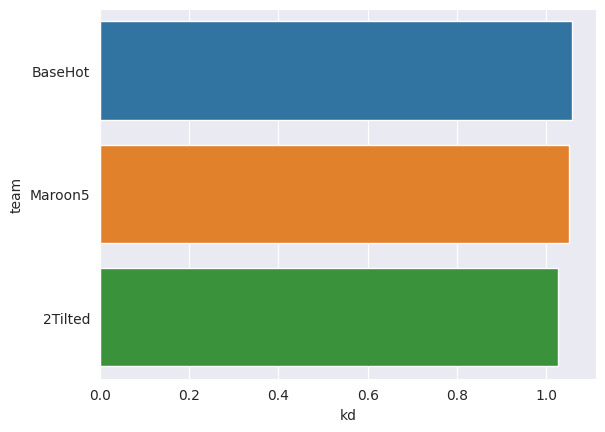

In [108]:
query = """
select distinct team,
    round(1.0 * (select count(1) from event_kill ek join player p on ek.killerPlayfabId = p.id where p.team = player.team)/
    (select count(1) from event_kill ek join player p on ek.victimPlayfabId = p.id where p.team = player.team),3) as kd
from player order by kd desc limit 3;
    """
result3 = pd.read_sql_query(query, con)
sns.barplot(result3, y="team", x="kd")

In [109]:
result3

,team,kd
0,BaseHot,1.058
1,Maroon5,1.050
2,2Tilted,1.027


## highest kill count average per round, top 5

<AxesSubplot: xlabel='avg_kills_per_round', ylabel='name'>

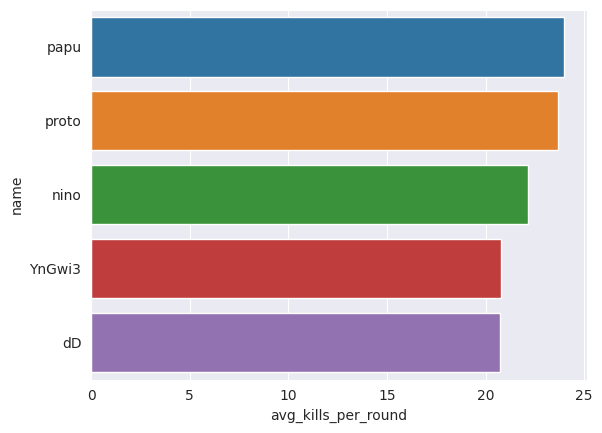

In [110]:
query = """
select player.name, player.team,
       round(1.0 * count(1)
       / (select count(distinct game + " " + round) from event_kill where killerPlayfabId = player.id)
             ,2) as avg_kills_per_round,
        (select weaponName from event_kill where killerPlayfabId = player.id group by weaponName order by count(1) desc limit 1) as most_used_weapon
from event_kill
         join player on id = killerPlayfabId
group by killerPlayfabId
order by avg_kills_per_round desc
limit 5
"""
result4 = pd.read_sql_query(query, con)
sns.barplot(result4, y="name", x="avg_kills_per_round")

In [111]:
result4

,name,team,avg_kills_per_round,most_used_weapon
0,papu,WeAreTeam7,23.95,SteyrAUG
1,proto,BaseHot,23.67,Kalashnikov
2,nino,Maroon5,22.16,MP5
3,YnGwi3,2Tilted,20.76,MP5
4,dD,NoMoreOverheat,20.74,MP5


### highest k/d, top 5

<AxesSubplot: xlabel='kd', ylabel='name'>

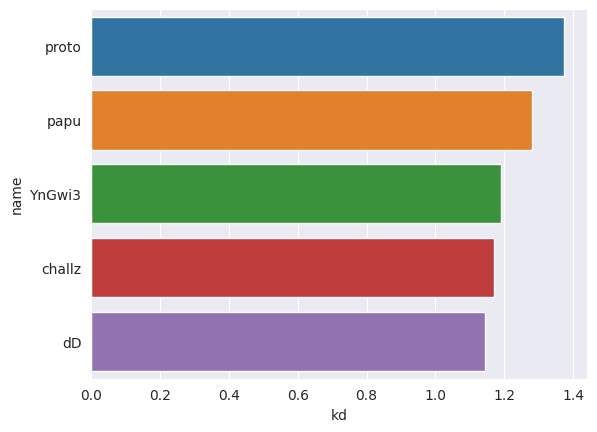

In [112]:
query = """
select name,
       round(1.0 * (select count(1) from event_kill where killerPlayfabId = id)/(select count(1) from event_kill where victimPlayfabId = id), 3) as kd
       from player order by kd desc limit 5
    """
result5 = pd.read_sql_query(query, con)
sns.barplot(result5, y="name", x="kd")

In [113]:
result5

,name,kd
0,proto,1.372
1,papu,1.281
2,YnGwi3,1.189
3,challz,1.169
4,dD,1.145


## Maps played

<AxesSubplot: xlabel='count', ylabel='mapName'>

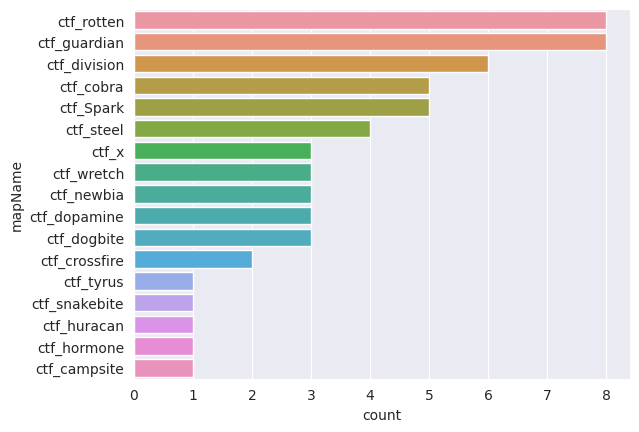

In [114]:
result6 = pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con)
sns.barplot(result6,
            y="mapName", x="count")

In [115]:
result6

,mapName,count
0,ctf_rotten,8
1,ctf_guardian,8
2,ctf_division,6
3,ctf_cobra,5
4,ctf_Spark,5
5,ctf_steel,4
6,ctf_x,3
7,ctf_wretch,3
8,ctf_newbia,3
9,ctf_dopamine,3


## avg caps per round

<AxesSubplot: xlabel='avg_caps_per_round', ylabel='mapName'>

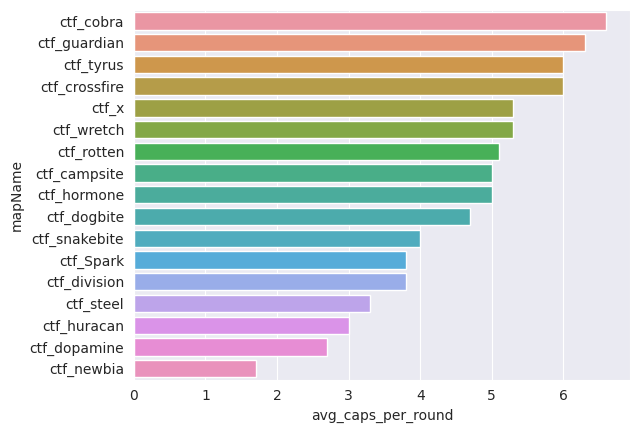

In [116]:

query = """
select distinct mapName,
round(1.0 *
    (select count(1) from event_cap c where r.mapName = c.mapName)/
    (select count(1) from round rr where r.mapName = rr.mapName), 1) avg_caps_per_round
from round r order by avg_caps_per_round desc;
"""
result7 = pd.read_sql_query(query, con)
sns.barplot(result7, y="mapName", x="avg_caps_per_round")

In [117]:
result7

,mapName,avg_caps_per_round
0,ctf_cobra,6.6
1,ctf_guardian,6.3
2,ctf_tyrus,6.0
3,ctf_crossfire,6.0
4,ctf_x,5.3
5,ctf_wretch,5.3
6,ctf_rotten,5.1
7,ctf_campsite,5.0
8,ctf_hormone,5.0
9,ctf_dogbite,4.7


## Weapons

### Kills per weapon

<AxesSubplot: xlabel='count', ylabel='weaponName'>

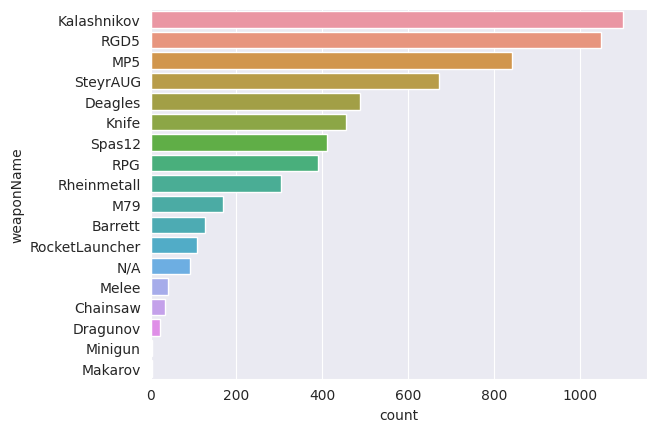

In [118]:
result8 = pd.read_sql_query(
    "select weaponName, count(1) as count from event_kill group by weaponName order by count desc", con)
sns.barplot(result8,
            y="weaponName", x="count")

In [119]:
result8

,weaponName,count
0,Kalashnikov,1100
1,RGD5,1049
2,MP5,842
3,SteyrAUG,671
4,Deagles,488
5,Knife,455
6,Spas12,410
7,RPG,390
8,Rheinmetall,303
9,M79,169
